# Import the necessary packages

In [ ]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cupyx.scipy.ndimage as csnd
import arm_em
import cupy as cp
from tqdm.auto import trange

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["image.cmap"] = "magma"

/home/qz7/anaconda3/envs/arm/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## Clear the font cache, and use Source Family fonts

In [ ]:
!rm -rf ~/.cache/matplotlib
from matplotlib import rcParams

rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["Source Sans 3", "Source Sans Pro"]
rcParams["font.serif"] = ["Source Serif 4", "Source Serif Pro"]
rcParams["font.monospace"] = ["Source Code Pro"]
rcParams["font.size"] = 25

## Set up CuPy memory management

In [ ]:
from rmm.allocators.cupy import rmm_cupy_allocator

cp.cuda.set_allocator(rmm_cupy_allocator)

## Let's test on a single datatset

In [ ]:
top_level, file_dict = arm_em.file_params()

In [ ]:
data_location = top_level + file_dict["data"]["PLGA_LA"]["Data"]
filetype = "mrc"
file_list = np.asarray(glob.glob(data_location + "*." + filetype), dtype="str")
data_mrc = mrcfile.open(file_list[2])

In [ ]:
ice_file = glob.glob(data_location + "*" + "124113." + filetype)
ice_data = mrcfile.open(ice_file[0])

The data_mrc is the mrc file, where the data has the image, and the header the calibrations

### Load the data as a CuPy array, and plot it to see how it looks like.

<matplotlib.image.AxesImage>

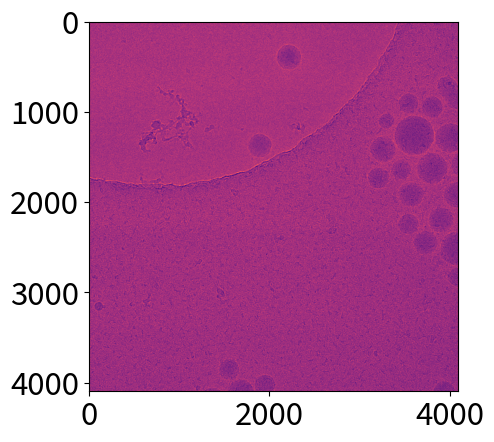

In [ ]:
im_data = cp.asarray(data_mrc.data, dtype=cp.float64)
plt.imshow(im_data.get())

<matplotlib.image.AxesImage>

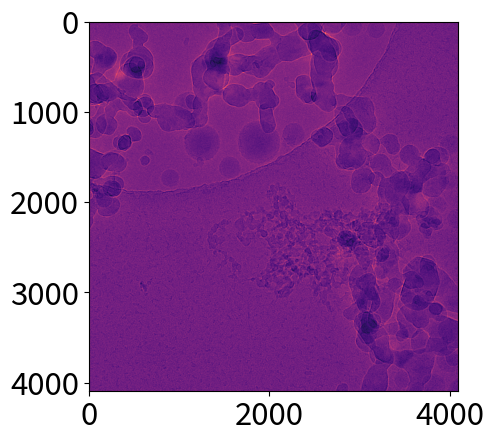

In [ ]:
ice_image = cp.asarray(ice_data.data, dtype=cp.float64)
plt.imshow(ice_image.get())

### The arm package has the `Laplacian of Gaussian` function. Let's call it to see how fast it runs

In [ ]:
%timeit arm_em.laplacian_gaussian(im_data, standard_deviation=15, sampling =(1/6))

25.8 ms ± 26 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Calling the function `JIT` compiles it, let's now run it on the image. We use some downsampling (`ds_factor`) to make it faster.

(-0.5, 682.5, 682.5, -0.5)

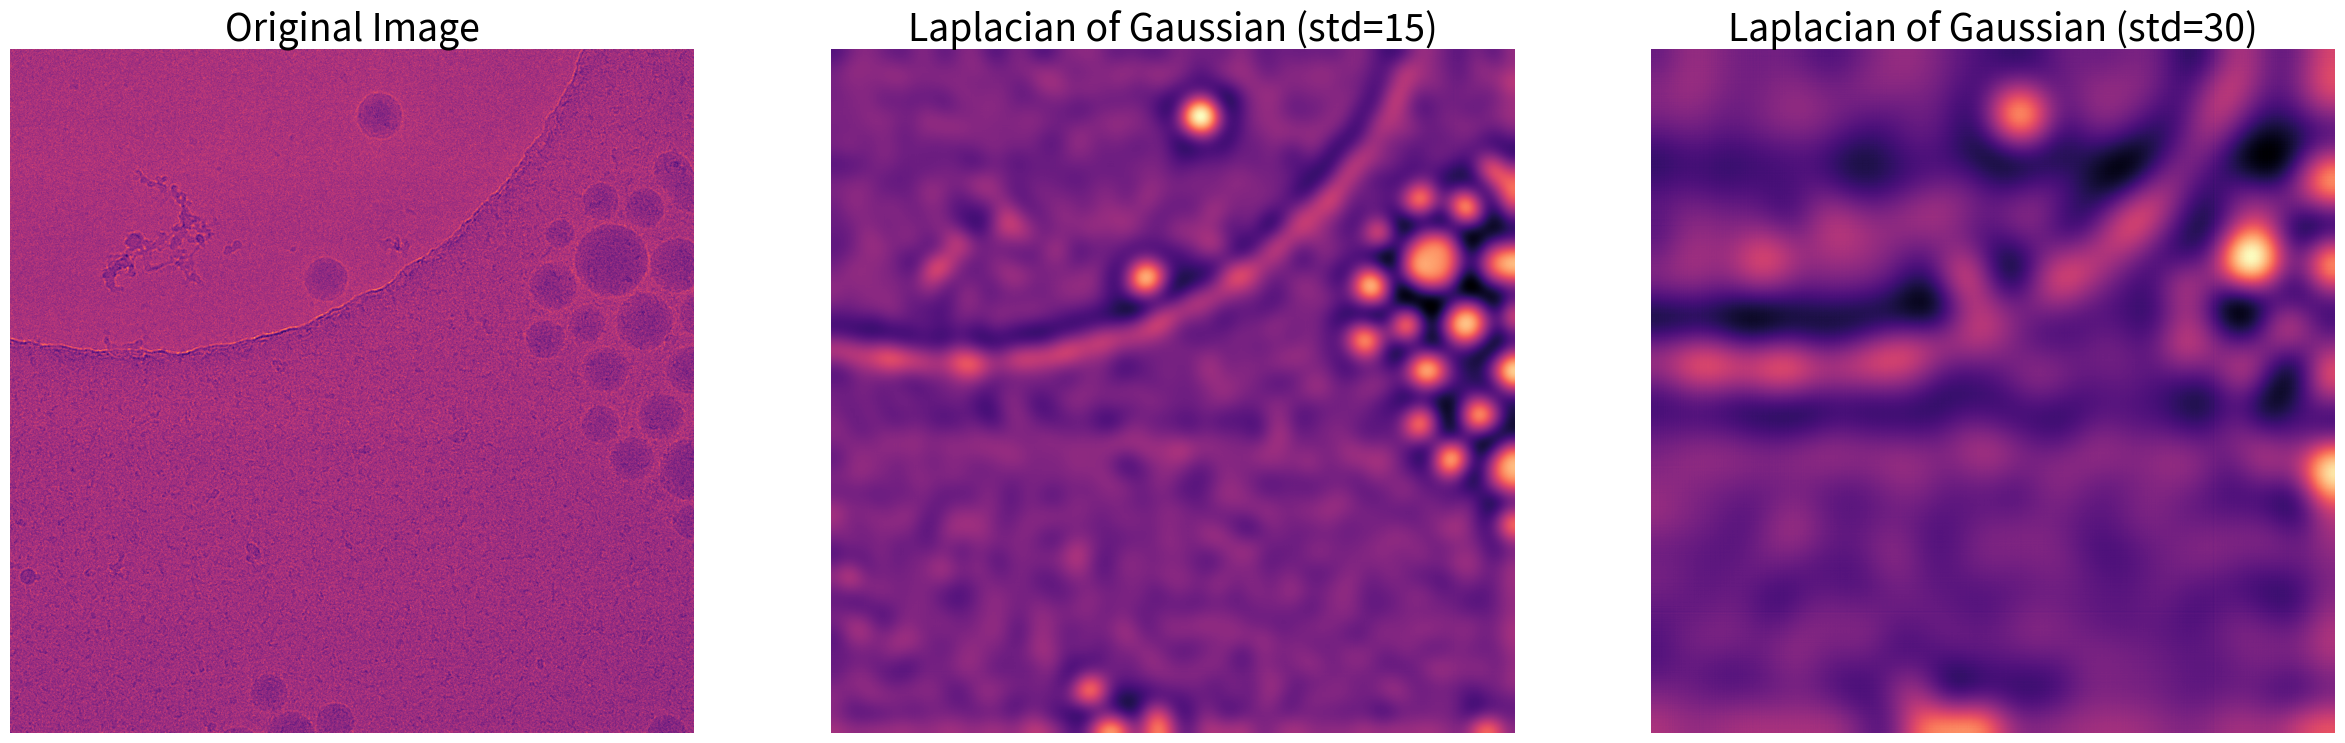

In [ ]:
ds_factor = 6

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(im_data.get())
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
std_val = 15  # The Standard Deviation
plt.imshow(
    arm_em.laplacian_gaussian(
        im_data, standard_deviation=std_val, sampling=(1 / ds_factor)
    ).get()
)
plt.title("Laplacian of Gaussian (std=" + str(std_val) + ")")
plt.axis("off")
plt.subplot(1, 3, 3)
std_val = 30  # The Standard Deviation
plt.imshow(
    arm_em.laplacian_gaussian(
        im_data, standard_deviation=std_val, sampling=(1 / ds_factor)
    ).get()
)
plt.title("Laplacian of Gaussian (std=" + str(std_val) + ")")
plt.axis("off")

(-0.5, 682.5, 682.5, -0.5)

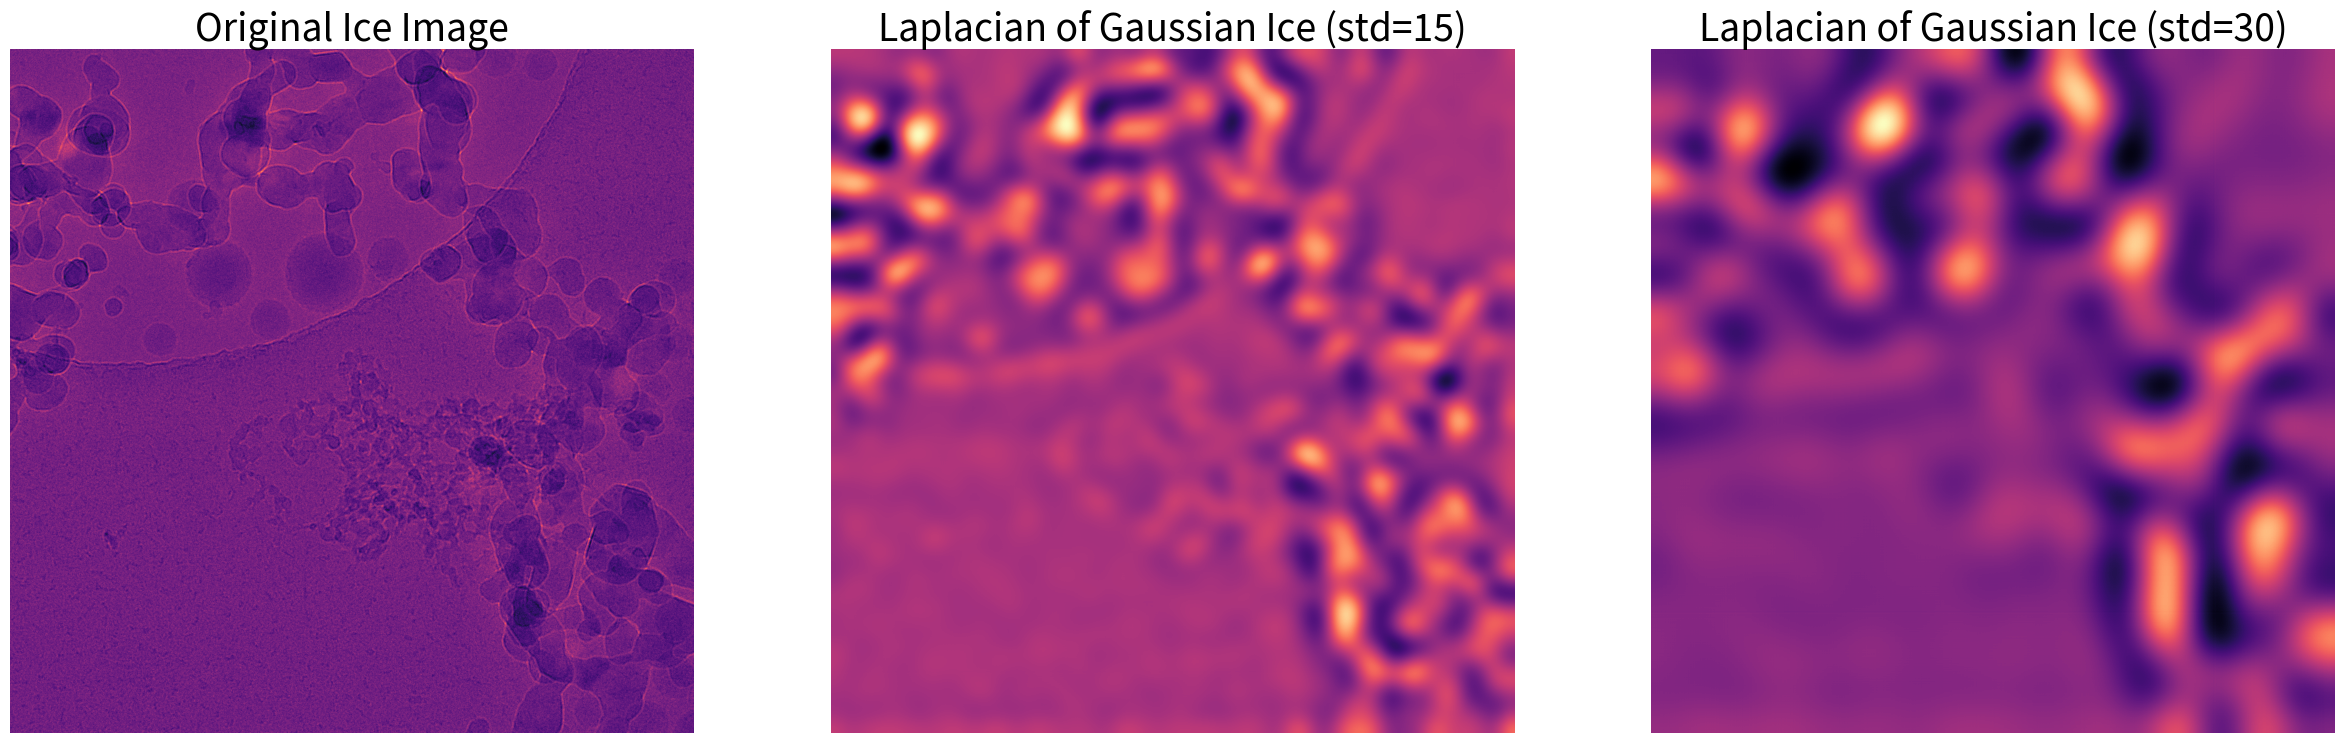

In [ ]:
ds_factor = 6

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(ice_image.get())
plt.title("Original Ice Image")
plt.axis("off")
plt.subplot(1, 3, 2)
std_val = 15  # The Standard Deviation
plt.imshow(
    arm_em.laplacian_gaussian(
        ice_image, standard_deviation=std_val, sampling=(1 / ds_factor)
    ).get()
)
plt.title("Laplacian of Gaussian Ice (std=" + str(std_val) + ")")
plt.axis("off")
plt.subplot(1, 3, 3)
std_val = 30  # The Standard Deviation
plt.imshow(
    arm_em.laplacian_gaussian(
        ice_image, standard_deviation=std_val, sampling=(1 / ds_factor)
    ).get()
)
plt.title("Laplacian of Gaussian Ice (std=" + str(std_val) + ")")
plt.axis("off")

### Now, we will run the `arm_em.blob_list` to JIT compile it, and see how it runs through a series of Standard Deviations and locates the blobs

In [ ]:
%timeit arm_em.blob_list(im_data, downscale=7)

496 ms ± 818 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
calculated_blob_pos = arm_em.blob_list(im_data, downscale=7).get()
circle_test = np.zeros_like(im_data.get())
yy, xx = np.mgrid[0 : circle_test.shape[0], 0 : circle_test.shape[1]]
for jj in trange(len(calculated_blob_pos)):
    circle_test += (
        ((yy - calculated_blob_pos[jj, 0]) ** 2)
        + ((xx - calculated_blob_pos[jj, 1]) ** 2)
    ) < (calculated_blob_pos[jj, 2] ** 2)
del yy, xx, jj

  0%|          | 0/36 [00:00<?, ?it/s]

### Let's plot the locations and sizes of the blobs. You will notice the blob sizes are still not correct!

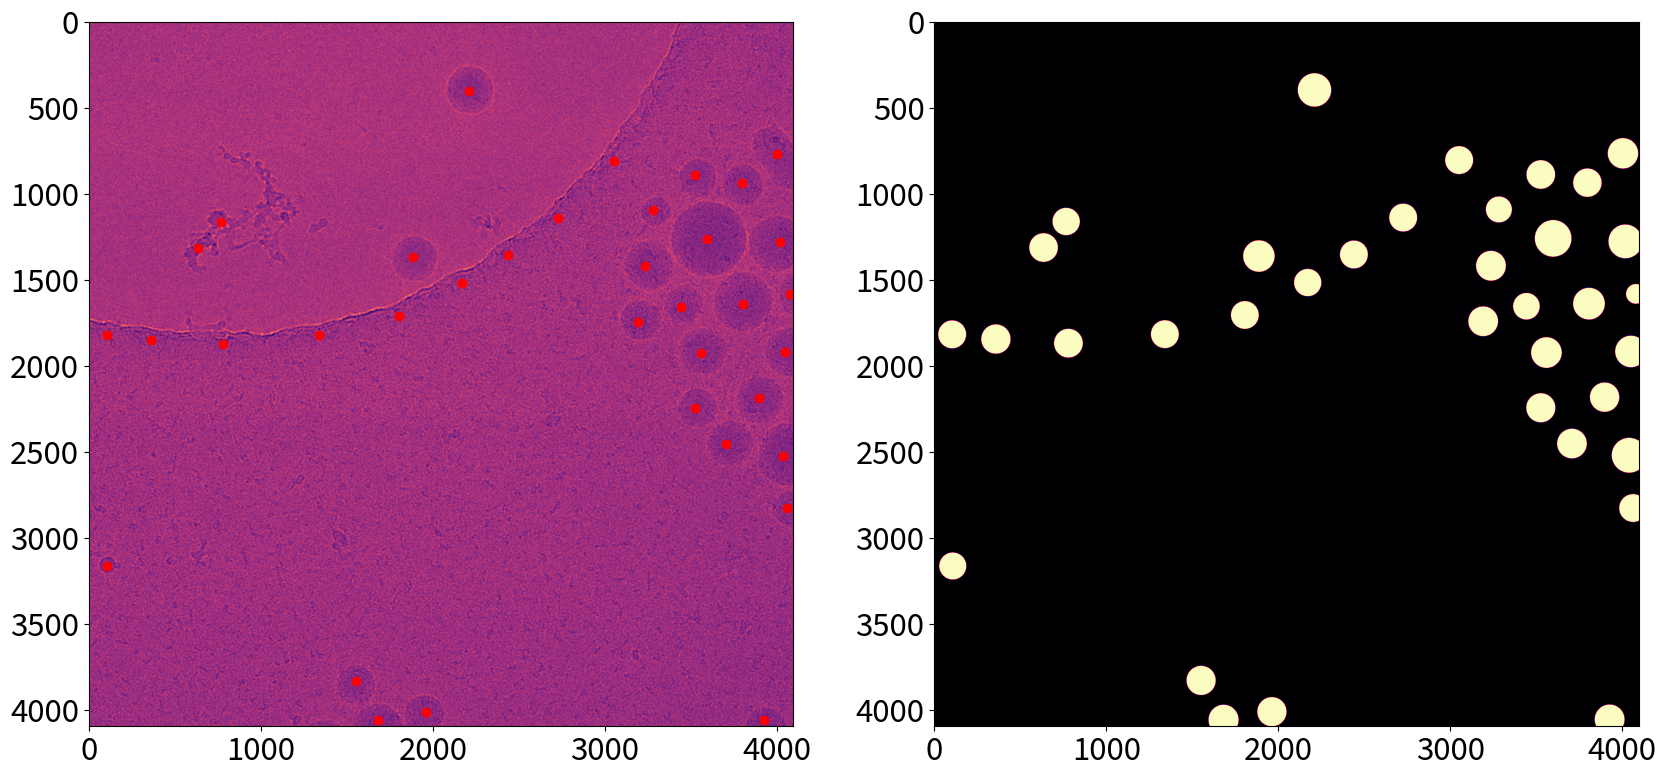

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im_data.get())
plt.scatter(calculated_blob_pos[:, 1], calculated_blob_pos[:, 0], c="r")
plt.subplot(1, 2, 2)
plt.imshow(circle_test)
plt.savefig(top_level + file_dict["results"]["PLGA_LA"] + "First_Run.pdf")

### Since we know the blobs can be calculated, let's run the code on the full folder. Here our function will go over the entire folder, and calculate blob sizes in nanometers for every MRC file in that folder.

In [ ]:
all_blobs = arm_em.folder_blobs(data_location)

  0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
hist_x, hist_y = np.histogram(np.asarray(all_blobs["Size (nm)"], dtype=float), bins=20)
hist_x, hist_y

(array([203, 151, 162, 165, 183, 182, 202, 214, 276, 253, 185, 246, 211,
        222, 203, 174, 156, 152, 123, 178]),
 array([   47.0845837 ,  1479.18765475,  2911.2907258 ,  4343.39379685,
         5775.4968679 ,  7207.59993894,  8639.70300999, 10071.80608104,
        11503.90915209, 12936.01222313, 14368.11529418, 15800.21836523,
        17232.32143628, 18664.42450733, 20096.52757837, 21528.63064942,
        22960.73372047, 24392.83679152, 25824.93986256, 27257.04293361,
        28689.14600466]))

#### Let's export this data as a CSV file to results

In [ ]:
all_blobs.to_csv(
    path_or_buf=top_level + file_dict["results"]["PLGA_LA"] + "Blob_List.csv"
)